### Projeto 1 da Disciplina Fundamentos de Sistemas Inteligentes
Aluno: Guilherme Rodrigues Lodron Pires <br>
Matrícula: 170011780

In [1]:
# Realizando todas as importações necessárias no projeto
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
#  Carregando os dados e observando as colunas do dataset
df = pd.read_csv('SA_heart.csv')
df.head(10)

,id,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1
5,6,132,6.20,6.47,36.21,Present,62,30.77,14.14,45,0
6,7,142,4.05,3.38,16.20,Absent,59,20.81,2.62,38,0
7,8,114,4.08,4.59,14.60,Present,62,23.11,6.72,58,1
8,9,114,0.00,3.83,19.40,Present,49,24.86,2.49,29,0
9,10,132,0.00,5.80,30.96,Present,69,30.11,0.00,53,1


In [2]:
# Pelo fato da feature 'famhist' ser categórica é possível torná-la numérica
df = pd.get_dummies(df, drop_first=True)
df = df.drop(columns=['id'])
df.head()

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,chd,famhist_Present
0,160,12.00,5.73,23.11,49,25.30,97.20,52,1,1
1,144,0.01,4.41,28.61,55,28.87,2.06,63,1,0
2,118,0.08,3.48,32.28,52,29.14,3.81,46,0,1
3,170,7.50,6.41,38.03,51,31.99,24.26,58,1,1
4,134,13.60,3.50,27.78,60,25.99,57.34,49,1,1


#### 1. Analisando os dados de maneira estatística e plotando informações relevantes

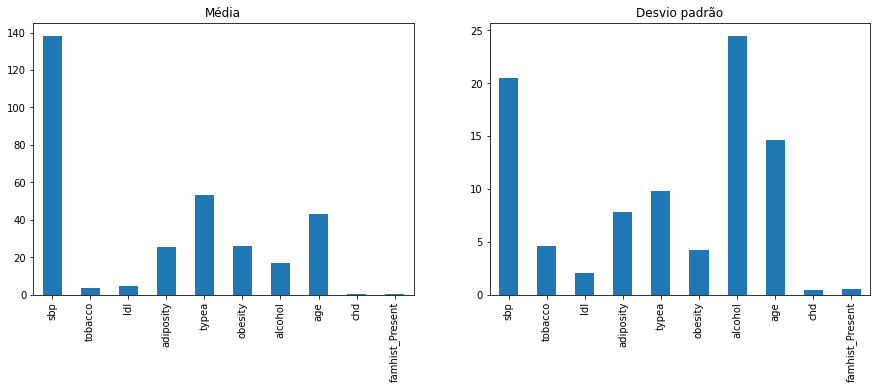

In [3]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
# Plotando médias
ax1 = df.describe().loc['mean'].plot.bar(title='Média', ax=ax1)
# Plotando desvio padrão
ax2 = df.describe().loc['std'].plot.bar(title='Desvio padrão', ax=ax2)
plt.show()

#### 2. Construindo um modelo de árvore para prever classificar os dados

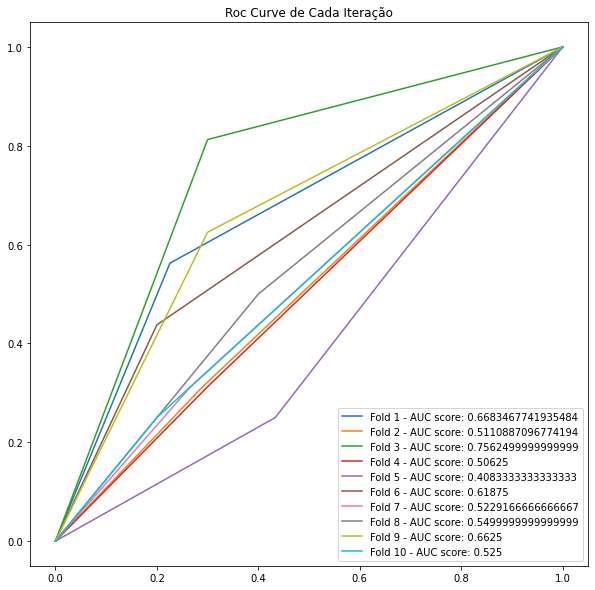

In [4]:
plt.figure(figsize=(10, 10))
SEED = 123

# Separando features e classes
feature_names = df.drop(columns='chd').keys()
X = df.drop(columns='chd').values
y = df['chd'].values

# variáveis que irão armazenar informações de cada iteração do cross validation
legends = []
scores = []
confusion_matrixes = []

# Instanciando classificador e kfold
skf = StratifiedKFold(n_splits=10)
dt = DecisionTreeClassifier()
i = 1

# Loop para iterar em todos os conjuntos de teste e treino
for train_indexes, test_indexes in skf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_indexes], X[test_indexes], y[train_indexes], y[test_indexes]
    dt.fit(X_train, y_train)
    y_pred_prob = dt.predict_proba(X_test)[:, 1]
    y_pred = dt.predict(X_test)
    # Salvando scores e matrizes de confusão
    confusion_matrixes.append(confusion_matrix(y_test, y_pred))
    auc_score = roc_auc_score(y_test, y_pred_prob)
    scores.append(auc_score)
    # Plotando curva ROC
    legends.append(f'Fold {i} - AUC score: {auc_score}')
    fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr)
    plt.title('Roc Curve de Cada Iteração')
    i += 1
plt.legend(legends)
plt.show()

### Matriz de confusão e score médio utilizando Decision Tree padrão

O auc score médio utilizando DecisionTreeClassifier é: 0.5729435483870967


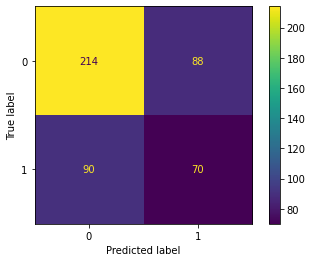

In [5]:
print(f'O auc score médio utilizando DecisionTreeClassifier é: {np.mean(scores)}')
confusion_matrix_final = np.add.reduce(confusion_matrixes)
cnf = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_final)
cnf.plot()
plt.show()

#### 3. Construindo um modelo de floresta randômica com 100 árvores utilizando todas as features

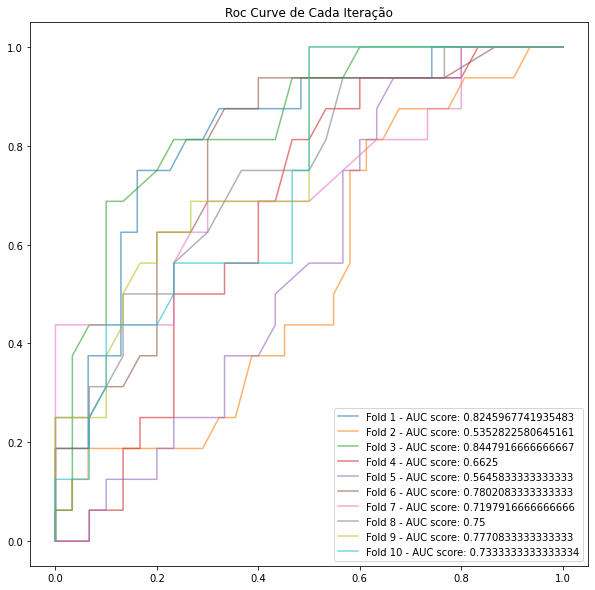

In [6]:
plt.figure(figsize=(10, 10))

# Instanciando classificador
rf_all_features = RandomForestClassifier(n_estimators=100, max_features=None, random_state=SEED)
i = 1

# variáveis que irão armazenar informações de cada iteração do cross validation
legends = []
scores = []
confusion_matrixes = []

# Loop para iterar em todos os conjuntos de teste e treino
for train_indexes, test_indexes in skf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_indexes], X[test_indexes], y[train_indexes], y[test_indexes]
    rf_all_features.fit(X_train, y_train)
    y_pred_prob = rf_all_features.predict_proba(X_test)[:, 1]
    y_pred = rf_all_features.predict(X_test)
    # Salvando scores e matrizes de confusão
    confusion_matrixes.append(confusion_matrix(y_test, y_pred))
    auc_score = roc_auc_score(y_test, y_pred_prob)
    scores.append(auc_score)
    legends.append(f'Fold {i} - AUC score: {auc_score}')
    # Plotando curva ROC
    fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, alpha=.6)
    plt.title('Roc Curve de Cada Iteração')
    i += 1

plt.legend(legends)
plt.show()

### Matriz de confusão e score médio utilizando Random Forest com todas as features

O auc score médio utilizando Random Forest com todas as features é: 0.7192170698924731


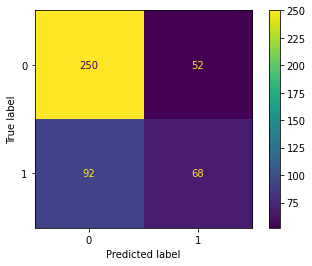

In [7]:
print(f'O auc score médio utilizando Random Forest com todas as features é: {np.mean(scores)}')
confusion_matrix_final = np.add.reduce(confusion_matrixes)
cnf = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_final)
cnf.plot()
plt.show()

#### 4. Construindo um modelo de floresta randômica com 100 árvores utilizando a raiz quadrada das features

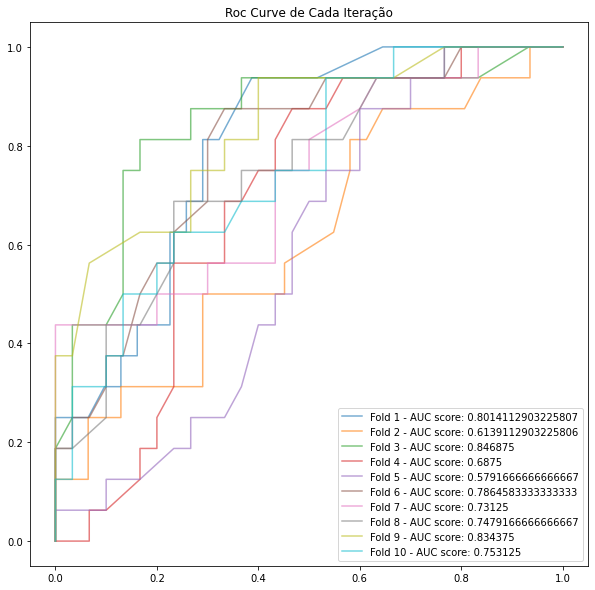

In [8]:
plt.figure(figsize=(10, 10))

# Instanciando classificador
rf_sqrt_features = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=SEED)
i = 1

# variáveis que irão armazenar informações de cada iteração do cross validation
legends = []
scores = []
confusion_matrixes = []
feature_importances = []

# Loop para iterar em todos os conjuntos de teste e treino
for train_indexes, test_indexes in skf.split(X, y):
    X_train, X_test, y_train, y_test = X[train_indexes], X[test_indexes], y[train_indexes], y[test_indexes]
    rf_sqrt_features.fit(X_train, y_train)
    y_pred_prob = rf_sqrt_features.predict_proba(X_test)[:, 1]
    y_pred = rf_sqrt_features.predict(X_test)
    # Salvando scores e matrizes de confusão
    confusion_matrixes.append(confusion_matrix(y_test, y_pred))
    auc_score = roc_auc_score(y_test, y_pred_prob)
    scores.append(auc_score)
    # Plotando curva ROC
    legends.append(f'Fold {i} - AUC score: {auc_score}')
    feature_importances.append(dt.feature_importances_)
    fpr, tpr, threshold = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, alpha=.6)
    plt.title('Roc Curve de Cada Iteração')
    i += 1

plt.legend(legends)
plt.show()
feature_importances_final = np.mean(feature_importances, axis=0)

### Matriz de confusão e score médio utilizando Random Forest com a raiz quadrada das features

O auc score médio utilizando Random Forest com a raiz quadrada das features: 0.7381989247311828


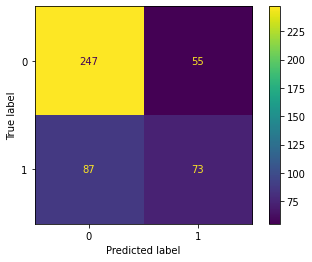

In [9]:
print(f'O auc score médio utilizando Random Forest com a raiz quadrada das features: {np.mean(scores)}')
confusion_matrix_final = np.add.reduce(confusion_matrixes)
cnf = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_final)
cnf.plot()
plt.show()

### 5. Pelo que pode ser observado o modelo que melhor performou foi o de Floresta Randômica <br> utilizando a raiz quadrada das features
#### Analisando features mais relevantes na classificação

De acordo com o modelo escolhido as taxas de ldl e a idade são os mais relevantes para a classificação

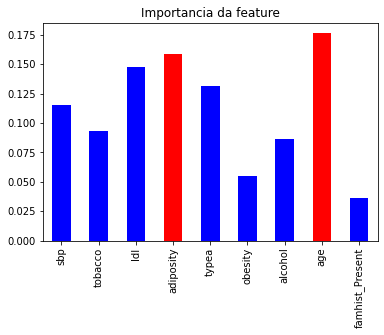

In [10]:
feature_importance_df = pd.Series(feature_importances_final, index=feature_names)
largest = pd.Series.nlargest(feature_importance_df, n=2).keys()
feature_importance_df.plot(kind='bar', color=['red' if np.isin(x, largest) else 'blue' for x in feature_importance_df.keys()])
plt.title('Importancia da feature')
plt.show()

Nesse projeto foi possível apresentar uma solução de diferentes maneiras para um dataset que retrata um problema real. <br>
O modelos de floresta randômica tiveram um desempenho significativamente melhor que a árvore de decisão, isso pode ser refletido com <br>
os estudos realizados em aula a respeito da maior adaptabilidade deste modelo em relação ao outro.

Ao comparar as duas estratégias de separação de features na floresta randômica, foi possível constatar que o modelo com a raiz quadrada <br>
das features performou melhor.